# 1. Setup and Get Data

### 1.1 Install Dependencies and Setup

In [1]:
#!pip install labelme tensorflow tensorflow-gpu opencv-python matplotlib albumentations

In [2]:
#!pip install labelme

In [3]:
#!pip install tensorflow

In [4]:
#!pip install matplotlib

In [5]:
#!pip install --upgrade setuptools wheel

In [6]:
#!pip3 install --editable  

In [7]:
#!pip install -U pip

In [8]:
#!pip cache purge 

In [9]:
#!pip install albumentations

In [10]:
#!pip install opencv-python

In [1]:
#!pip install Augmentor

In [1]:
#conda install -c intel mkl

In [1]:
import os
import time
import uuid
import cv2

In [2]:
IMAGES_PATH = os.path.join('data','images')
number_images = 90

In [3]:
def main():
    windowName = "Main"
    cv2.namedWindow(windowName)
    cap = cv2.VideoCapture(0)

    print('Width :' + str(cap.get(3)))
    print('Height :' + str(cap.get(4)))

    cap.set(3, 620)
    cap.set(4, 720)

    for imgnum in range(number_images):
        print('Collecting image {}'.format(imgnum))
        ret, frame = cap.read()
        imgname = os.path.join(IMAGES_PATH,f'{str(uuid.uuid1())}.jpg')
        cv2.imshow('Main', frame)
        cv2.imwrite(imgname, frame)
        time.sleep(1.5)   

        if cv2.waitKey(1) & 0xFF == ord('q'):

            cv2.destroyAllWindow()
            cap.release()    

if __name__== "__main__":
    main() 

2024-10-18 14:36:00.774 python[85671:2693357] WARNING: AVCaptureDeviceTypeExternal is deprecated for Continuity Cameras. Please use AVCaptureDeviceTypeContinuityCamera and add NSCameraUseContinuityCameraDeviceType to your Info.plist.


Width :1280.0
Height :720.0


### 1.2 Collect Images Using OpenCV

### 1.3 Annotate Images with LabelMe

In [1]:
!labelme

Skipping unexpected key in config: ai
Skipping unexpected key in config: fill_drawing
Skipping unexpected key in config: ai_polygon
Skipping unexpected key in config: ai_mask
Skipping unexpected key in config: show_all_polygons
Skipping unexpected key in config: hide_all_polygons
Skipping unexpected key in config: toggle_all_polygons


# 2. Review Dataset and Build Image Loading Function

### 2.1 Import TF and Deps

In [56]:
import tensorflow as tf
import json
import numpy as np
from matplotlib import pyplot as plt

### 2.2 Limit GPU Memory Growth

In [57]:
# Avoid OOM errors by setting GPU Memory Consumption Growth
#gpus = tf.config.experimental.list_physical_devices('GPU')
#for gpu in gpus: 
    #tf.config.experimental.set_memory_growth(gpu, True)

In [58]:
#tf.config.list_physical_devices('GPU')

### 2.3 Load Image into TF Data Pipeline

In [5]:
#images = tf.data.Dataset.list_files('data/images/*.jpg', shuffle=False)

In [6]:
images = tf.data.Dataset.list_files('data/images/*.jpg')

In [7]:
images.as_numpy_iterator().next()

b'data/images/b3db06ec-8d90-11ef-b7d1-a683e7996e5e.jpg'

In [8]:
def load_image(x): 
    byte_img = tf.io.read_file(x)
    img = tf.io.decode_jpeg(byte_img)
    return img

In [9]:
images = images.map(load_image)

In [10]:
images.as_numpy_iterator().next()

array([[[161, 157, 148],
        [162, 158, 149],
        [162, 158, 149],
        ...,
        [119, 113, 101],
        [118, 112, 100],
        [116, 110,  98]],

       [[160, 156, 147],
        [160, 156, 147],
        [160, 156, 147],
        ...,
        [119, 113, 101],
        [118, 112, 100],
        [118, 112, 100]],

       [[158, 154, 143],
        [158, 154, 143],
        [158, 154, 143],
        ...,
        [120, 114, 102],
        [120, 114, 102],
        [120, 114, 102]],

       ...,

       [[112, 110,  97],
        [112, 110,  97],
        [112, 110,  97],
        ...,
        [ 70,  69,  74],
        [ 72,  70,  75],
        [ 81,  79,  84]],

       [[111, 112,  98],
        [110, 111,  97],
        [110, 111,  97],
        ...,
        [ 70,  69,  74],
        [ 77,  75,  80],
        [ 95,  93,  98]],

       [[111, 112,  98],
        [110, 111,  97],
        [110, 111,  97],
        ...,
        [ 74,  73,  78],
        [ 85,  83,  88],
        [108, 106, 111]]

In [11]:
type(images)

tensorflow.python.data.ops.map_op._MapDataset

### 2.4 View Raw Images with Matplotlib

In [12]:
image_generator = images.batch(4).as_numpy_iterator()

In [13]:
plot_images = image_generator.next()

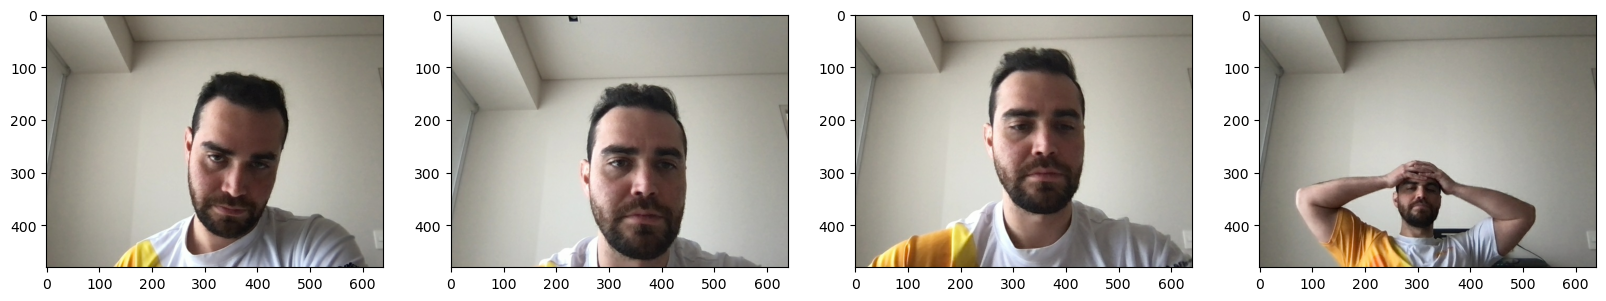

In [14]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, image in enumerate(plot_images):
    ax[idx].imshow(image) 
plt.show()

# 3. Partition Unaugmented Data

### 3.1 MANUALLY SPLT DATA INTO TRAIN TEST AND VAL

In [15]:
#90*.7 # 63 to train

In [18]:
#90*.15 # 14 and 13 to test and val
import os

### 3.2 Move the Matching Labels

In [20]:
for folder in ['train','test','val']:
    for file in os.listdir(os.path.join('data', folder, 'images')):
        
        filename = file.split('.')[0]+'.json'
        existing_filepath = os.path.join('data','labels', filename)
        if os.path.exists(existing_filepath): 
            new_filepath = os.path.join('data',folder,'labels',filename)
            os.replace(existing_filepath, new_filepath)      

# 4. Apply Image Augmentation on Images and Labels using Albumentations

### 4.1 Setup Albumentations Transform Pipeline

In [40]:
import albumentations as alb
import cv2

In [41]:
augmentor = alb.Compose([alb.RandomCrop(width=450, height=450), 
                         alb.HorizontalFlip(p=0.5), 
                         alb.RandomBrightnessContrast(p=0.2),
                         alb.RandomGamma(p=0.2), 
                         alb.RGBShift(p=0.2), 
                         alb.VerticalFlip(p=0.5)], 
                       bbox_params=alb.BboxParams(format='albumentations', 
                                                  label_fields=['class_labels']))

### 4.2 Load a Test Image and Annotation with OpenCV and JSON

In [42]:
img = cv2.imread(os.path.join('data','train', 'images','9a3269d8-8d90-11ef-b7d1-a683e7996e5e.jpg'))

In [43]:
with open(os.path.join('data', 'train', 'labels', '9a3269d8-8d90-11ef-b7d1-a683e7996e5e.json'), 'r') as f:
    label = json.load(f)

In [44]:
label['shapes'][0]['points']

[[237.80303030303034, 52.121212121212125],
 [460.5303030303031, 381.66666666666663]]

### 4.3 Extract Coordinates and Rescale to Match Image Resolution

In [45]:
coords = [0,0,0,0]
coords[0] = label['shapes'][0]['points'][0][0]
coords[1] = label['shapes'][0]['points'][0][1]
coords[2] = label['shapes'][0]['points'][1][0]
coords[3] = label['shapes'][0]['points'][1][1]

In [46]:
coords

[237.80303030303034, 52.121212121212125, 460.5303030303031, 381.66666666666663]

In [47]:
coords = list(np.divide(coords, [640,480,640,480]))

In [48]:
coords

[0.3715672348484849,
 0.10858585858585859,
 0.7195785984848486,
 0.7951388888888888]

### 4.4 Apply Augmentations and View Results

In [49]:
augmented = augmentor(image=img, bboxes=[coords], class_labels=['face'])

In [50]:
augmented['bboxes'][0][2:]

[0.7137710232204861, 0.8481481552124024]

In [51]:
augmented['bboxes']

[[0.21882151285807294,
  0.11582491397857667,
  0.7137710232204861,
  0.8481481552124024]]

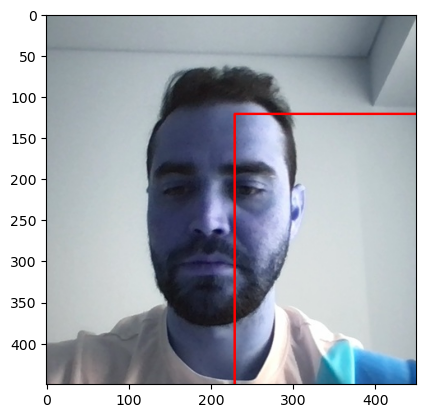

In [52]:
cv2.rectangle(augmented['image'], 
              tuple(np.multiply(augmented['bboxes'][0][:2], [1050,1050]).astype(int)),
              tuple(np.multiply(augmented['bboxes'][0][2:], [1050,1050]).astype(int)), 
                    (255,0,0), 2)

plt.imshow(augmented['image'])

# 5. Build and Run Augmentation Pipeline

### 5.1 Run Augmentation Pipeline

In [60]:
import numpy as np
for partition in ['train','test','val']: 
    for image in os.listdir(os.path.join('data', partition, 'images')):
        img = cv2.imread(os.path.join('data', partition, 'images', image))

        coords = [0,0,0.00001,0.00001]
        label_path = os.path.join('data', partition, 'labels', f'{image.split(".")[0]}.json')
        if os.path.exists(label_path):
            with open(label_path, 'r') as f:
                label = json.load(f)

            coords[0] = label['shapes'][0]['points'][0][0]
            coords[1] = label['shapes'][0]['points'][0][1]
            coords[2] = label['shapes'][0]['points'][1][0]
            coords[3] = label['shapes'][0]['points'][1][1]
            coords = list(np.divide(coords, [640,480,640,480]))

        try: 
            for x in range(60):
                augmented = augmentor(image=img, bboxes=[coords], class_labels=['face'])
                cv2.imwrite(os.path.join('aug_data', partition, 'images', f'{image.split(".")[0]}.{x}.jpg'), augmented['image'])

                annotation = {}
                annotation['image'] = image

                if os.path.exists(label_path):
                    if len(augmented['bboxes']) == 0: 
                        annotation['bbox'] = [0,0,0,0]
                        annotation['class'] = 0 
                    else: 
                        annotation['bbox'] = augmented['bboxes'][0]
                        annotation['class'] = 1
                else: 
                    annotation['bbox'] = [0,0,0,0]
                    annotation['class'] = 0 


                with open(os.path.join('aug_data', partition, 'labels', f'{image.split(".")[0]}.{x}.json'), 'w') as f:
                    json.dump(annotation, f)

        except Exception as e:
            print(e)

image must be numpy array type


### 5.2 Load Augmented Images to Tensorflow Dataset

In [61]:
train_images = tf.data.Dataset.list_files('aug_data/train/images/*.jpg', shuffle=False) 
train_images = train_images.map(load_image)
train_images = train_images.map(lambda x: tf.image.resize(x, (120,120)))
train_images = train_images.map(lambda x: x/255)

In [62]:
test_images = tf.data.Dataset.list_files('aug_data/test/images/*.jpg', shuffle=False)
test_images = test_images.map(load_image)
test_images = test_images.map(lambda x: tf.image.resize(x, (120,120)))
test_images = test_images.map(lambda x: x/255)

In [63]:
val_images = tf.data.Dataset.list_files('aug_data/val/images/*.jpg', shuffle=False)
val_images = val_images.map(load_image)
val_images = val_images.map(lambda x: tf.image.resize(x, (120,120)))
val_images = val_images.map(lambda x: x/255)

In [64]:
train_images.as_numpy_iterator().next()

array([[[0.05398284, 0.05006127, 0.04221814],
        [0.05637255, 0.05245098, 0.04460784],
        [0.05490196, 0.05098039, 0.04313726],
        ...,
        [0.09411765, 0.09411765, 0.09411765],
        [0.09803922, 0.09803922, 0.09803922],
        [0.09718137, 0.09411765, 0.09564951]],

       [[0.05490196, 0.05098039, 0.04313726],
        [0.05876226, 0.05484069, 0.04699755],
        [0.05833333, 0.05441177, 0.04656863],
        ...,
        [0.09019608, 0.09019608, 0.09019608],
        [0.09019608, 0.09019608, 0.09019608],
        [0.09050245, 0.09050245, 0.09050245]],

       [[0.05851716, 0.05459559, 0.04675245],
        [0.05790441, 0.05398284, 0.04613971],
        [0.05496323, 0.05104167, 0.04319853],
        ...,
        [0.09362745, 0.09362745, 0.09362745],
        [0.09019608, 0.09019608, 0.09019608],
        [0.09068628, 0.09068628, 0.09068628]],

       ...,

       [[0.07028186, 0.07028186, 0.07028186],
        [0.07009804, 0.07009804, 0.06911765],
        [0.0632353 , 0

# 6. Prepare Labels

### 6.1 Build Label Loading Function

In [65]:
def load_labels(label_path):
    with open(label_path.numpy(), 'r', encoding = "utf-8") as f:
        label = json.load(f)
        
    return [label['class']], label['bbox']

### 6.2 Load Labels to Tensorflow Dataset

In [66]:
train_labels = tf.data.Dataset.list_files('aug_data/train/labels/*.json', shuffle=False)
train_labels = train_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.uint8, tf.float16]))

In [67]:
test_labels = tf.data.Dataset.list_files('aug_data/test/labels/*.json', shuffle=False)
test_labels = test_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.uint8, tf.float16]))

In [68]:
val_labels = tf.data.Dataset.list_files('aug_data/val/labels/*.json', shuffle=False)
val_labels = val_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.uint8, tf.float16]))

In [69]:
train_labels.as_numpy_iterator().next()

(array([0], dtype=uint8), array([0., 0., 0., 0.], dtype=float16))

# 7. Combine Label and Image Samples

### 7.1 Check Partition Lengths

In [70]:
len(train_images), len(train_labels), len(test_images), len(test_labels), len(val_images), len(val_labels)

(3600, 3600, 900, 900, 900, 900)

### 7.2 Create Final Datasets (Images/Labels)

In [73]:
train = tf.data.Dataset.zip((train_images, train_labels))
train = train.shuffle(4000)
train = train.batch(8)
train = train.prefetch(4)

In [74]:
test = tf.data.Dataset.zip((test_images, test_labels))
test = test.shuffle(1000)
test = test.batch(8)
test = test.prefetch(4)

In [75]:
val = tf.data.Dataset.zip((val_images, val_labels))
val = val.shuffle(1000)
val = val.batch(8)
val = val.prefetch(4)

In [76]:
train.as_numpy_iterator().next()[0].shape

(8, 120, 120, 3)

### 7.3 View Images and Annotations

In [77]:
data_samples = train.as_numpy_iterator()

In [78]:
res = data_samples.next()

error: OpenCV(4.10.0) :-1: error: (-5:Bad argument) in function 'rectangle'
> Overload resolution failed:
>  - img marked as output argument, but provided NumPy array marked as readonly
>  - Expected Ptr<cv::UMat> for argument 'img'
>  - img marked as output argument, but provided NumPy array marked as readonly
>  - Expected Ptr<cv::UMat> for argument 'img'


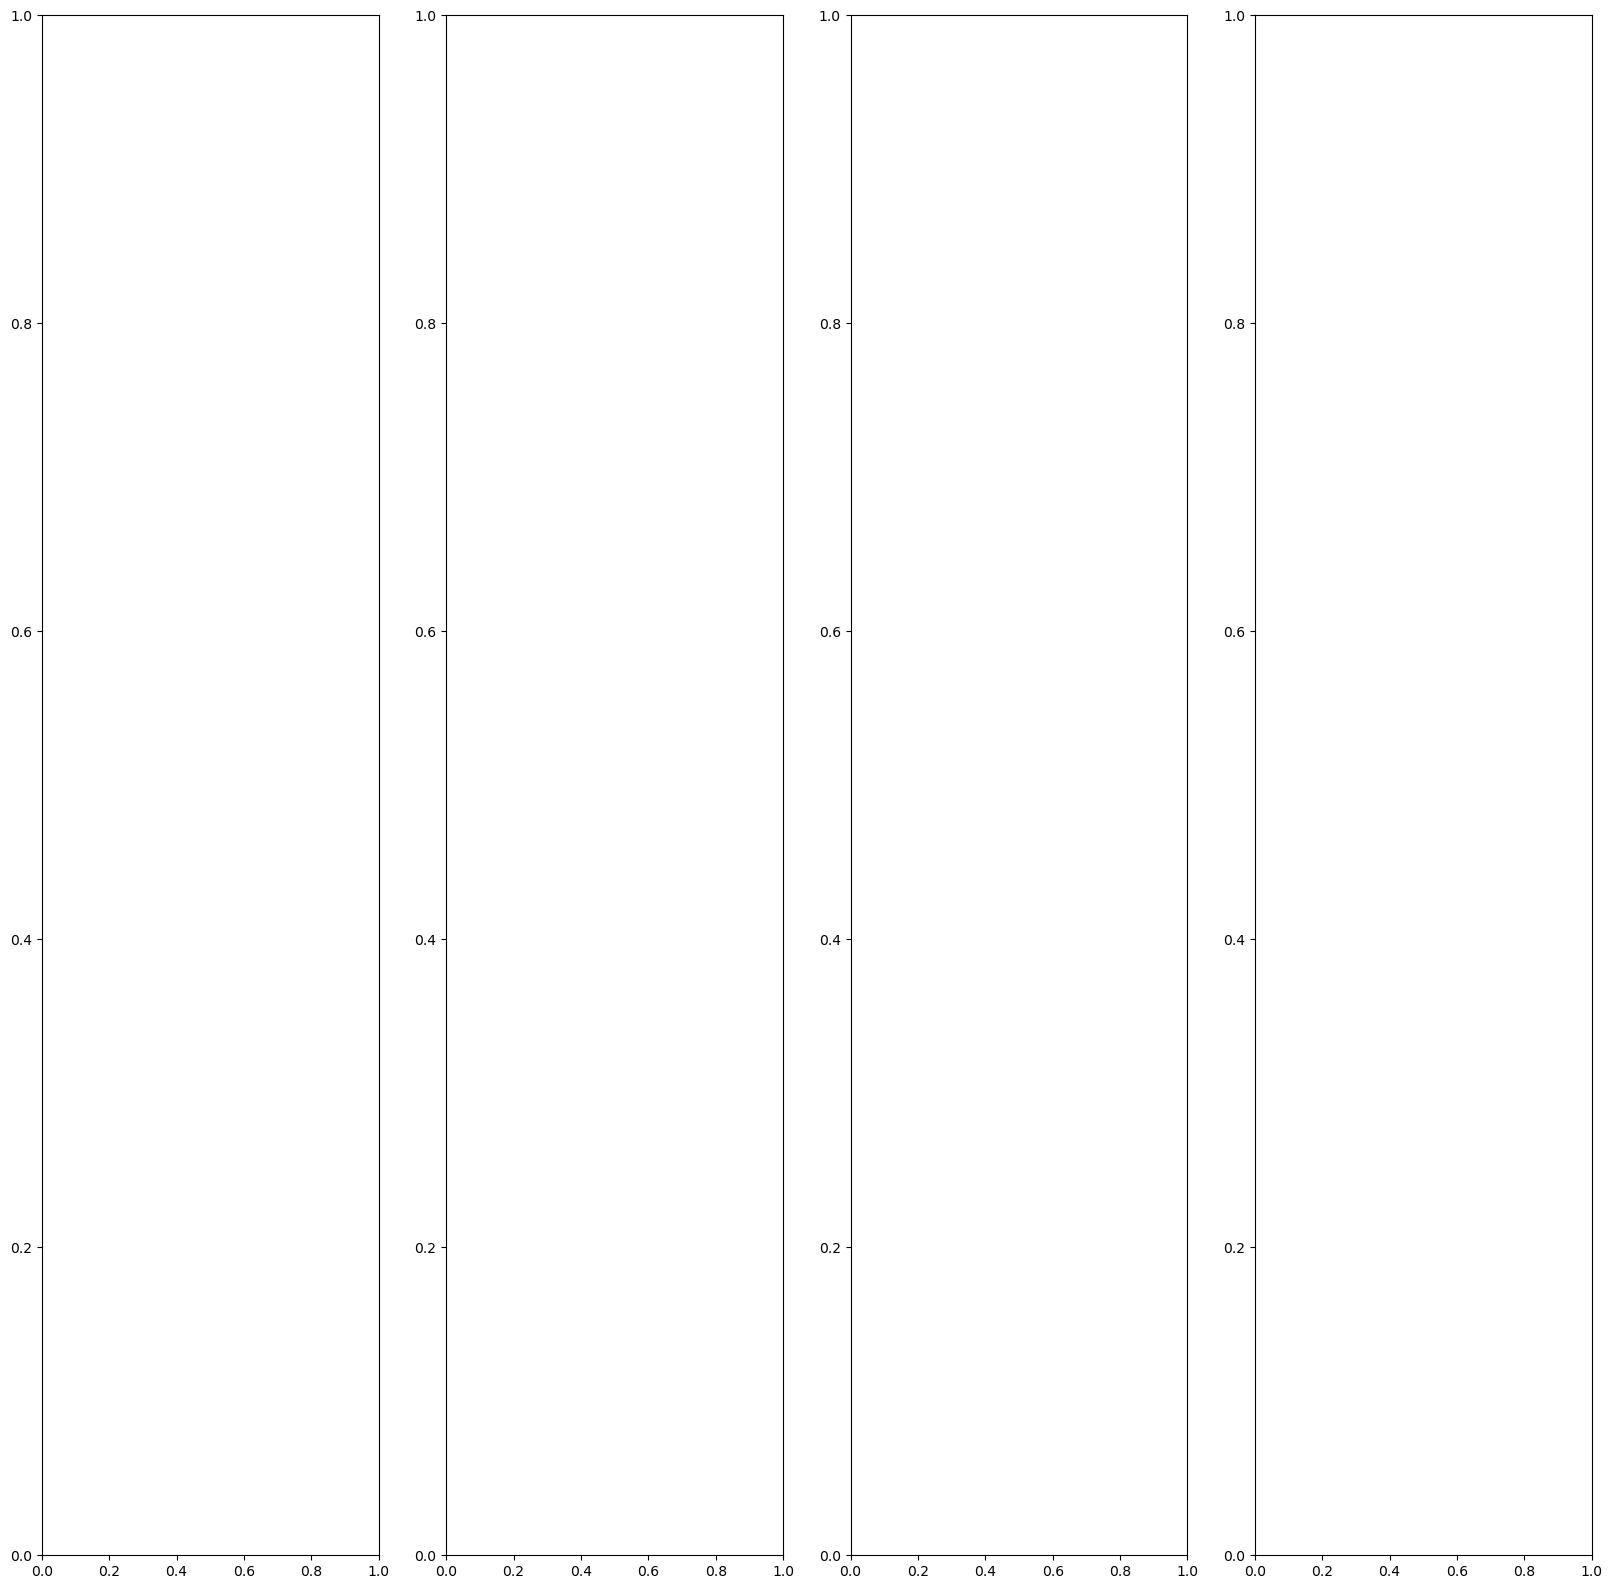

In [79]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx in range(4): 
    sample_image = res[0][idx]
    sample_coords = res[1][1][idx]
    
    cv2.rectangle(sample_image, 
                  tuple(np.multiply(sample_coords[:2], [120,120]).astype(int)),
                  tuple(np.multiply(sample_coords[2:], [120,120]).astype(int)), 
                        (255,0,0), 2)

    ax[idx].imshow(sample_image)

# 8. Build Deep Learning using the Functional API

### 8.1 Import Layers and Base Network

In [80]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, Dense, GlobalMaxPooling2D
from tensorflow.keras.applications import VGG16

### 8.2 Download VGG16

In [81]:
vgg = VGG16(include_top=False)

In [82]:
vgg.summary()

Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, None, None, 3)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, None, None, 64) │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, None, None, 64) │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, None, None, 64) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, None, None,     │        73,856 │
│                                 │ 128)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, None, None,     │       147,584 │
│                                 │ 128)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, None, None,     │             0 │
│                                 │ 128)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, None, None,     │       295,168 │
│                                 │ 256)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, None, None,     │       590,080 │
│                                 │ 256)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, None, None,     │       590,080 │
│                                 │ 256)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, None, None,     │             0 │
│                                 │ 256)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, None, None,     │     1,180,160 │
│                                 │ 512)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, None, None,     │     2,359,808 │
│                                 │ 512)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, None, None,     │     2,359,808 │
│                                 │ 512)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, None, None,     │             0 │
│                                 │ 512)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, None, None,     │     2,359,808 │
│                                 │ 512)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, None, None,     │     2,359,808 │
│                                 │ 512)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, None, None,     │     2,359,808 │
│                                 │ 512)                   │             

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 14,714,688 (56.13 MB)

 Non-trainable params: 0 (0.00 B)

### 8.3 Build instance of Network

In [83]:
def build_model(): 
    input_layer = Input(shape=(120,120,3))
    
    vgg = VGG16(include_top=False)(input_layer)

    # Classification Model  
    f1 = GlobalMaxPooling2D()(vgg)
    class1 = Dense(2048, activation='relu')(f1)
    class2 = Dense(1, activation='sigmoid')(class1)
    
    # Bounding box model
    f2 = GlobalMaxPooling2D()(vgg)
    regress1 = Dense(2048, activation='relu')(f2)
    regress2 = Dense(4, activation='sigmoid')(regress1)
    
    facetracker = Model(inputs=input_layer, outputs=[class2, regress2])
    return facetracker

In [84]:
train.as_numpy_iterator().next()[1]

(array([[1],
        [1],
        [1],
        [1],
        [1],
        [0],
        [0],
        [0]], dtype=uint8),
 array([[0.     , 0.1958 , 0.4343 , 0.676  ],
        [0.06604, 0.1443 , 0.61   , 0.7925 ],
        [0.2085 , 0.1586 , 0.653  , 0.8267 ],
        [0.3481 , 0.1238 , 0.776  , 0.765  ],
        [0.2212 , 0.2343 , 0.718  , 0.9146 ],
        [0.     , 0.     , 0.     , 0.     ],
        [0.     , 0.     , 0.     , 0.     ],
        [0.     , 0.     , 0.     , 0.     ]], dtype=float16))

### 8.4 Test out Neural Network

In [85]:
facetracker = build_model()

In [86]:
facetracker.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 120, 120,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ vgg16 (Functional)  │ (None, 3, 3, 512) │ 14,714,688 │ input_layer_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_max_pooling… │ (None, 512)       │          0 │ vgg16[0][0]       │
│ (GlobalMaxPooling2… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_max_pooling… │ (None, 512)       │          0 │ vgg16[0][0]       │
│ (GlobalMaxPooling2… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 2048)      │  1,050,624 │ global_max_pooli… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 2048)      │  1,050,624 │ global_max_pooli… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 1)         │      2,049 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 4)         │      8,196 │ dense_2[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 16,826,181 (64.19 MB)

 Trainable params: 16,826,181 (64.19 MB)

 Non-trainable params: 0 (0.00 B)

In [87]:
X, y = train.as_numpy_iterator().next()

In [88]:
X.shape

(8, 120, 120, 3)

In [89]:
classes, coords = facetracker.predict(X)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 682ms/step


In [90]:
classes, coords

(array([[0.44696385],
        [0.31167135],
        [0.3979982 ],
        [0.44610924],
        [0.35321176],
        [0.39510012],
        [0.3619632 ],
        [0.3777771 ]], dtype=float32),
 array([[0.3061896 , 0.52655643, 0.53678495, 0.5951499 ],
        [0.25651798, 0.5024614 , 0.4839454 , 0.583802  ],
        [0.31224558, 0.5500194 , 0.5883873 , 0.57117003],
        [0.43341443, 0.58787394, 0.49511987, 0.52299535],
        [0.32963172, 0.5575591 , 0.5393182 , 0.5801459 ],
        [0.31198573, 0.5770904 , 0.42252845, 0.6318952 ],
        [0.26613358, 0.61325914, 0.4788047 , 0.5839406 ],
        [0.44929695, 0.6102309 , 0.5048476 , 0.49465853]], dtype=float32))

# 9. Define Losses and Optimizers

### 9.1 Define Optimizer and LR

In [91]:
len(train)

450

In [92]:
batches_per_epoch = len(train)
lr_decay = (1./0.75 -1)/batches_per_epoch

In [93]:
opt = tf.keras.optimizers.Adam(learning_rate=0.0001, decay=lr_decay)

/Users/leonzlotnik/opt/anaconda3/lib/python3.12/site-packages/keras/src/optimizers/base_optimizer.py:33: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(


### 9.2 Create Localization Loss and Classification Loss

In [94]:
def localization_loss(y_true, yhat):            
    delta_coord = tf.reduce_sum(tf.square(y_true[:,:2] - yhat[:,:2]))
                  
    h_true = y_true[:,3] - y_true[:,1] 
    w_true = y_true[:,2] - y_true[:,0] 

    h_pred = yhat[:,3] - yhat[:,1] 
    w_pred = yhat[:,2] - yhat[:,0] 
    
    delta_size = tf.reduce_sum(tf.square(w_true - w_pred) + tf.square(h_true-h_pred))
    
    return delta_coord + delta_size

In [95]:
classloss = tf.keras.losses.BinaryCrossentropy()
regressloss = localization_loss

### 9.3 Test out Loss Metrics

In [96]:
localization_loss(y[1], coords).numpy() #no da el decimal igaul

4.4829326

In [97]:
classloss(y[0], classes).numpy()

0.86789405

In [98]:
regressloss(y[1], coords)

<tf.Tensor: shape=(), dtype=float32, numpy=4.4829326>

In [99]:
tf.print(y[0].shape)

(8, 1)


In [100]:
tf.print(classes.shape)

(8, 1)


# 10. Train Neural Network

### 10.1 Create Custom Model Class

In [101]:
class FaceTracker(Model): 
    def __init__(self, eyetracker,  **kwargs): 
        super().__init__(**kwargs)
        self.model = eyetracker

    def compile(self, opt, classloss, localizationloss, **kwargs):
        super().compile(**kwargs)
        self.closs = classloss
        self.lloss = localizationloss
        self.opt = opt
    
    def train_step(self, batch, **kwargs): 
        
        X, y = batch
        
        with tf.GradientTape() as tape: 
            classes, coords = self.model(X, training=True)

            #y[0] = tf.ensure_shape(y[0],(0,))
            
            #batch_classloss = self.closs(tf.reshape(y[0],(-1,)), tf.reshape(classes,(-1,)))
            batch_classloss = self.closs(y[0], classes)
            batch_localizationloss = self.lloss(tf.cast(y[1], tf.float32), coords)
            
            total_loss = batch_localizationloss+0.5*batch_classloss
            
            grad = tape.gradient(total_loss, self.model.trainable_variables)
        
        opt.apply_gradients(zip(grad, self.model.trainable_variables))
        
        return {"total_loss":total_loss, "class_loss":batch_classloss, "regress_loss":batch_localizationloss}
    
    def test_step(self, batch, **kwargs): 
        X, y = batch
        
        classes, coords = self.model(X, training=False)
        
        #batch_classloss = self.closs(y[0], classes)
        batch_localizationloss = self.lloss(tf.cast(y[1], tf.float32), coords)
        total_loss = batch_localizationloss+0.5*batch_classloss
        
        return {"total_loss":total_loss, "class_loss":batch_classloss, "regress_loss":batch_localizationloss}
        
    def call(self, X, **kwargs): 
        return self.model(X, **kwargs)

In [102]:
model = FaceTracker(facetracker)

In [103]:
model.compile(opt, classloss, regressloss)

### 10.2 Train

In [104]:
logdir='logs'

In [105]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [106]:
hist = model.fit(train, epochs=40, validation_data=val, callbacks=[tensorboard_callback])

Epoch 1/40


ValueError: Cannot take the length of shape with unknown rank.

### 10.3 Plot Performance

In [52]:
hist.history

NameError: name 'hist' is not defined

NameError: name 'hist' is not defined

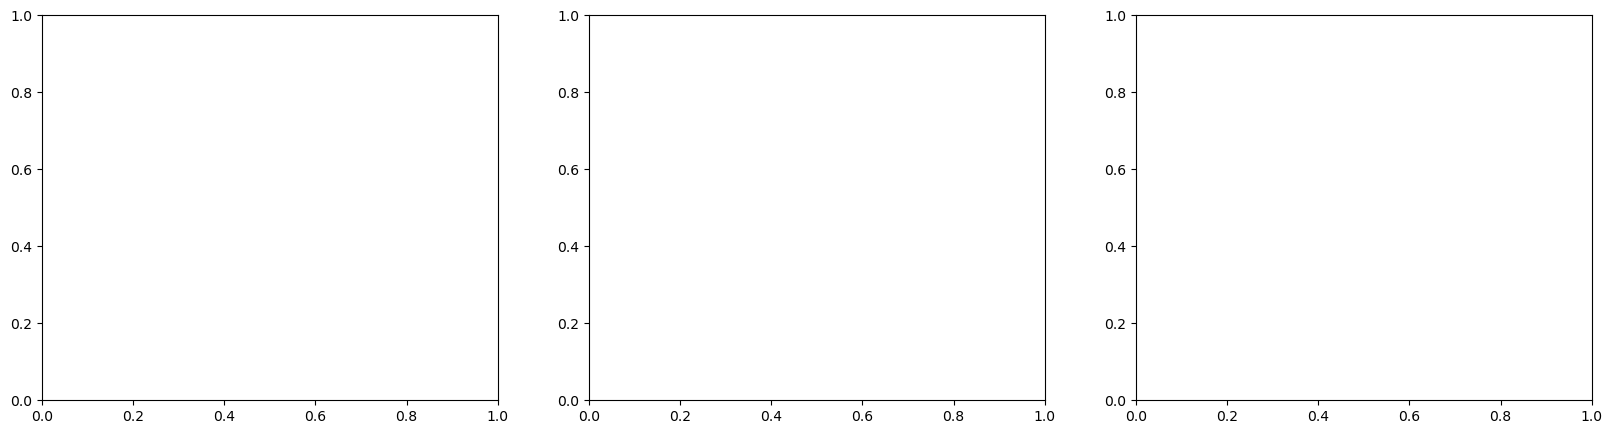

In [53]:
fig, ax = plt.subplots(ncols=3, figsize=(20,5))

ax[0].plot(hist.history['total_loss'], color='teal', label='loss')
ax[0].plot(hist.history['val_total_loss'], color='orange', label='val loss')
ax[0].title.set_text('Loss')
ax[0].legend()

ax[1].plot(hist.history['class_loss'], color='teal', label='class loss')
ax[1].plot(hist.history['val_class_loss'], color='orange', label='val class loss')
ax[1].title.set_text('Classification Loss')
ax[1].legend()

ax[2].plot(hist.history['regress_loss'], color='teal', label='regress loss')
ax[2].plot(hist.history['val_regress_loss'], color='orange', label='val regress loss')
ax[2].title.set_text('Regression Loss')
ax[2].legend()

plt.show()

# 11. Make Predictions

### 11.1 Make Predictions on Test Set

In [ ]:
test_data = test.as_numpy_iterator()

In [ ]:
test_sample = test_data.next()

In [ ]:
yhat = facetracker.predict(test_sample[0])

In [ ]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx in range(4): 
    sample_image = test_sample[0][idx]
    sample_coords = yhat[1][idx]
    
    if yhat[0][idx] > 0.9:
        cv2.rectangle(sample_image, 
                      tuple(np.multiply(sample_coords[:2], [120,120]).astype(int)),
                      tuple(np.multiply(sample_coords[2:], [120,120]).astype(int)), 
                            (255,0,0), 2)
    
    ax[idx].imshow(sample_image)

### 11.2 Save the Model

In [ ]:
from tensorflow.keras.models import load_model

In [ ]:
facetracker.save('facetracker.h5')

In [ ]:
facetracker = load_model('facetracker.h5')

### 11.3 Real Time Detection

In [ ]:
cap = cv2.VideoCapture(1)
while cap.isOpened():
    _ , frame = cap.read()
    frame = frame[50:500, 50:500,:]
    
    rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    resized = tf.image.resize(rgb, (120,120))
    
    yhat = facetracker.predict(np.expand_dims(resized/255,0))
    sample_coords = yhat[1][0]
    
    if yhat[0] > 0.5: 
        # Controls the main rectangle
        cv2.rectangle(frame, 
                      tuple(np.multiply(sample_coords[:2], [450,450]).astype(int)),
                      tuple(np.multiply(sample_coords[2:], [450,450]).astype(int)), 
                            (255,0,0), 2)
        # Controls the label rectangle
        cv2.rectangle(frame, 
                      tuple(np.add(np.multiply(sample_coords[:2], [450,450]).astype(int), 
                                    [0,-30])),
                      tuple(np.add(np.multiply(sample_coords[:2], [450,450]).astype(int),
                                    [80,0])), 
                            (255,0,0), -1)
        
        # Controls the text rendered
        cv2.putText(frame, 'face', tuple(np.add(np.multiply(sample_coords[:2], [450,450]).astype(int),
                                               [0,-5])),
                    cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 2, cv2.LINE_AA)
    
    cv2.imshow('EyeTrack', frame)
    
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break
cap.release()
cv2.destroyAllWindows()